<a href="https://colab.research.google.com/github/tbeucler/2023_SD_REP/blob/main/Figures_Tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We designed this notebook so that it can be run in Google Colab. To prepare the data, **please upload `RV_Zip_Count.csv`and `Spatial_Join_SVI.dbf` in "Files"**.  

We will install the required Python libraries, pre-process the data, then calculate simple statistics, and finally reproduce the study's figures.

# Python Libraries Installation and Import

In [72]:
# Install the required libraries (we specify the version to facilitate reproducibility)
!pip install pandas==1.5.3
!pip install simpledbf==0.2.6
!pip install numpy==1.23.0
!pip install matplotlib==3.7.2

In [73]:
# Import the required libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import simpledbf
from simpledbf import Dbf5

# Data Pre-Processing

## Calculate the drop in Week 10-15 respiratory visits between 2016-2019 and 2020 per San Diego zipcode

In [74]:
# Read the data from a CSV file
rv_zip_count = pd.read_csv('RV_Zip_Count.csv')

In [75]:
# Duplicate rv_zip_count, but only keep 'week_of_year' from 10 to 15
rv_zip_count_week_10_15 = rv_zip_count[rv_zip_count['week_of_year'].isin([10, 11, 12, 13, 14, 15])]

In [76]:
# Per zip code and per year, sum all the patients from 'week_of_year' from 10 to 15
rv_zip_sum_week_10_15 = rv_zip_count_week_10_15.groupby(['zip', 'year'])['Number of patients'].sum().reset_index()

In [77]:
# Now average all years together except 2020
# Average all years together except 2020
diff = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] != 2020]
diff = (diff.groupby('zip')['Number of patients'].sum()/4).reset_index()

In [78]:
# Replace the name of the column "Number of patients" with "2016-2019" in diff
diff.rename(columns={'Number of patients': '2016-2019'}, inplace=True)

In [79]:
# Extract the number of patients in 2020 from rv_zip_sum_week_10_15
rv_zip_2020 = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] == 2020]

In [80]:
# Loop over zipcodes in diff to merge the 2016-2019 & 2020 visits in the same structure
# If the zipcode is in rv_zip_2020, assign rv_zip_2020['Number of patients'] to diff['2020']
for index, row in diff.iterrows():
  if row['zip'] in rv_zip_2020['zip'].values:
    diff.loc[index, '2020'] = rv_zip_2020.loc[rv_zip_2020['zip'] == row['zip']]['Number of patients'].values[0]
  else: diff.loc[index, '2020'] = 0.0

In [81]:
# Subtract the number of patients in diff from the number of patients in rv_zip_2020
# Divide weeks 10-15 by 6 to get weekly drop in pediatric respiratory visits
diff['six-week-diff'] = (diff['2020'] - diff['2016-2019'])
diff['drop_in_patients'] = -diff['six-week-diff']/6

In [82]:
# Only keep San Diego zipcodes
# Delete all rows corresponding to 'zip' greater than 92199 and smaller than 91901
diff = diff[(diff['zip'] <= 92199) & (diff['zip'] >= 91901)]

In [83]:
diff

,zip,2016-2019,2020,six-week-diff,drop_in_patients
149,91901,9.75,8.0,-1.75,0.291667
150,91902,10.25,5.0,-5.25,0.875000
151,91903,0.50,0.0,-0.50,0.083333
152,91905,1.25,0.0,-1.25,0.208333
153,91906,4.50,4.0,-0.50,0.083333
...,...,...,...,...,...
273,92177,0.25,1.0,0.75,-0.125000
274,92178,0.25,1.0,0.75,-0.125000
275,92192,0.50,0.0,-0.50,0.083333
276,92196,0.25,0.0,-0.25,0.041667


## Pre-Process database containing spatially-joined zipcodes and CDC social vulnerability indices

In [84]:
# Path to the spatially-joined zipcode and SVIs
path_dbf = '/content/Spatial_Join_Zip_SVI.dbf'

In [85]:
dbf = Dbf5(path_dbf) # Load dbf file
svi = dbf.to_dataframe() # Convert to pd dataframe
svi['zip'] = svi['zip'].astype('int') # Convert zipcodes to integers
svi = svi.replace(-999, np.nan) # Replace -999 values with NaN following CDC conventions

In [86]:
# Group SVI statistics by zip code
svi_zip = {}
svi_zip['zipcode'] = svi.groupby('zip')['zip'].unique().astype('int')

svi_zip['all_mean'] = svi.groupby('zip')['RPL_THEMES'].mean()
svi_zip['socioeconomic_mean'] = svi.groupby('zip')['RPL_THEME1'].mean()
svi_zip['household_mean'] = svi.groupby('zip')['RPL_THEME2'].mean()
svi_zip['minority_mean'] = svi.groupby('zip')['RPL_THEME3'].mean()
svi_zip['housing_mean'] = svi.groupby('zip')['RPL_THEME4'].mean()

svi_zip['all_min'] = svi.groupby('zip')['RPL_THEMES'].min()
svi_zip['socioeconomic_min'] = svi.groupby('zip')['RPL_THEME1'].min()
svi_zip['household_min'] = svi.groupby('zip')['RPL_THEME2'].min()
svi_zip['minority_min'] = svi.groupby('zip')['RPL_THEME3'].min()
svi_zip['housing_min'] = svi.groupby('zip')['RPL_THEME4'].min()

svi_zip['all_max'] = svi.groupby('zip')['RPL_THEMES'].max()
svi_zip['socioeconomic_max'] = svi.groupby('zip')['RPL_THEME1'].max()
svi_zip['household_max'] = svi.groupby('zip')['RPL_THEME2'].max()
svi_zip['minority_max'] = svi.groupby('zip')['RPL_THEME3'].max()
svi_zip['housing_max'] = svi.groupby('zip')['RPL_THEME4'].max()

In [87]:
# Convert svi_zip to a pandas dataframe
svi_zip = pd.DataFrame(svi_zip)

## Link mean weekly drop in respiratory visits to CDC social vulnerability indices

In [88]:
# Merge diff with svi_zip based on 'zip'
svi_zip_diff = svi_zip.merge(diff, on='zip')

# Simple statistics

In [89]:
# Find the column that anti-correlates best with the 'diff' column
# Use Pearson correlation coefficient to find the column that correlates best with 'diff'
corr_matrix = svi_zip_diff.corr(method='pearson', numeric_only=True)
# Find the column that correlates best with the 'drop_in_patients' column
best_corr = corr_matrix['drop_in_patients'].sort_values(ascending=False)

In [90]:
best_corr

drop_in_patients      1.000000
2016-2019             0.487933
minority_max          0.395504
minority_mean         0.382384
all_max               0.330821
household_max         0.328728
2020                  0.303415
socioeconomic_max     0.275342
housing_max           0.273742
minority_min          0.192178
all_mean              0.183204
socioeconomic_mean    0.165366
household_mean        0.106115
housing_mean          0.089007
zipcode               0.039119
zip                   0.039119
socioeconomic_min    -0.070746
all_min              -0.119467
household_min        -0.161922
housing_min          -0.207925
six-week-diff        -1.000000
Name: drop_in_patients, dtype: float64

In [94]:
# Extract county-mean SVIs
best_corr_mean = {k:v for k,v in best_corr.items() if 'mean' in k}

In [95]:
best_corr_mean

{'minority_mean': 0.38238386573476707,
 'all_mean': 0.1832035777504049,
 'socioeconomic_mean': 0.16536637890313388,
 'household_mean': 0.10611452347326496,
 'housing_mean': 0.08900725832392199}

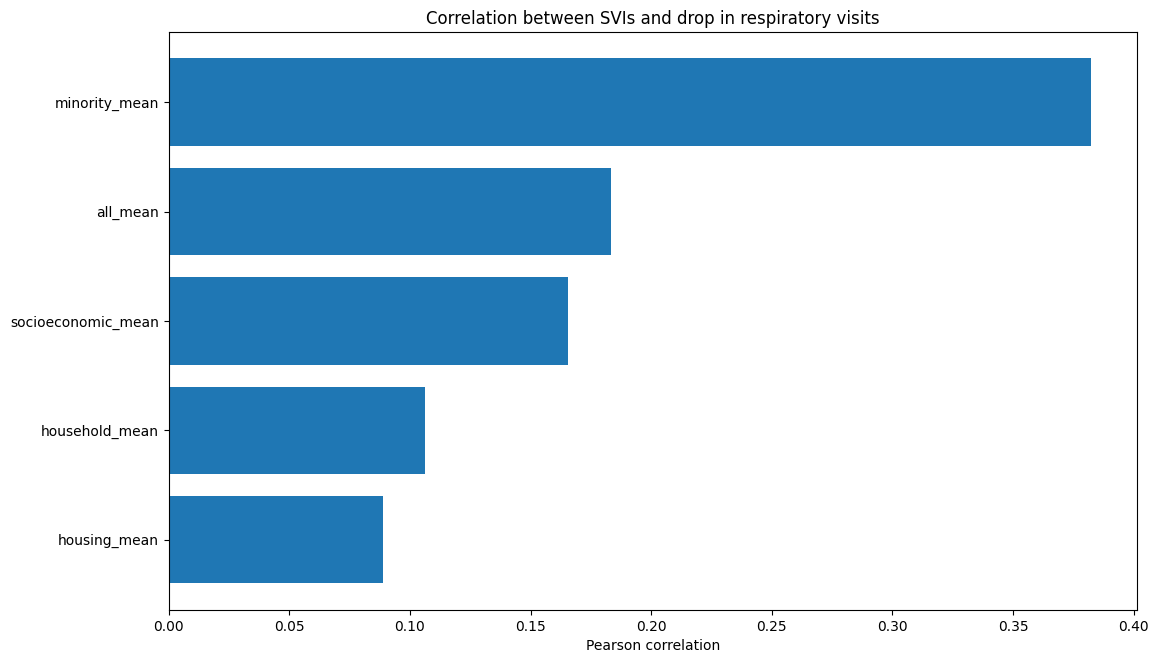

In [96]:
# Turn it into a horizontal bar plot
fig,ax = plt.subplots(figsize=(12.5,7.5))
# extract labels and values
labels = list(best_corr_mean.keys())
values = list(best_corr_mean.values())
labels = labels[::-1] # change the order to go from most to least correlated
values = values[::-1] # ditto

# create a horizontal bar plot
plt.barh(labels, values)

# add labels and title
plt.xlabel('Pearson correlation')
plt.title('Correlation between SVIs and drop in respiratory visits')

fig.savefig('Pearson_correlations.pdf', format='pdf')